# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.645894,False,-0.817237
1,0.609774,True,5.597123
2,-1.053980,True,3.492926
3,-0.671034,True,4.483084
4,-2.997548,False,-1.741693
...,...,...,...
995,-1.190869,False,-0.294971
996,-2.110739,False,0.703033
997,-1.614011,False,0.287097
998,-2.738416,False,-1.153067


<AxesSubplot: xlabel='v0'>

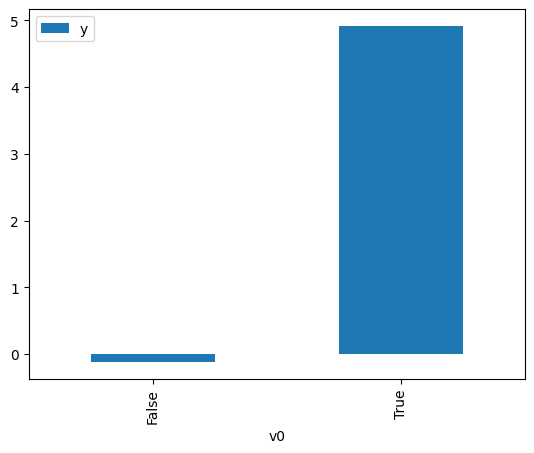

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

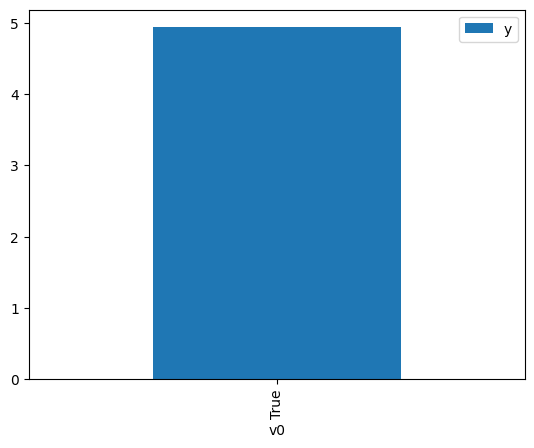

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.580798,False,1.133153,0.277602,3.602285
1,-0.877724,False,-1.397868,0.775750,1.289074
2,-1.142106,False,-0.526214,0.837453,1.194097
3,-0.707756,False,0.140035,0.728097,1.373443
4,-2.336862,False,-1.798105,0.968915,1.032082
...,...,...,...,...,...
995,0.534101,False,0.021948,0.291929,3.425492
996,-2.019490,False,0.518945,0.950795,1.051752
997,-1.964045,False,-0.463182,0.946736,1.056261
998,0.050816,False,0.250552,0.460607,2.171050


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.076089,True,6.614238,0.491676,2.033860
1,-1.588769,True,4.518704,0.090105,11.098197
2,-2.465911,True,5.258092,0.025734,38.859833
3,-0.671034,True,4.483084,0.282993,3.533658
4,-1.360671,True,4.161403,0.122529,8.161330
...,...,...,...,...,...
995,-0.510375,True,4.265431,0.334565,2.988956
996,-0.573624,True,4.444125,0.313694,3.187816
997,0.093817,True,2.846773,0.555443,1.800365
998,0.601382,True,5.300749,0.728574,1.372543


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              3480.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:48:39   Log-Likelihood:                         -1415.4
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     998   BIC:                                      2845.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1681      0.023      7.248      0.000       0.123       0.214
x2             5.0404      0.060     83.422      0.000       4.922       5.159
==============================================================================
Omnibus:                        0.884   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.939
Skew:                          -0.015   Prob(JB):                        0.625
Kurtosis:                       2.853   Cond. No.                         2.61
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""